In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc

# Import Dataset

In [2]:
ifmha = pd.read_csv('./tauraat-230322-150349.csv', converters={'site_no': str}, low_memory=False)
ifmha.shape

(2064782, 49)

In [3]:
ifmha['site_no'].value_counts().describe()

count    6498.000000
mean      317.756540
std       269.268215
min        50.000000
25%       154.000000
50%       258.000000
75%       387.000000
max      6580.000000
Name: site_no, dtype: float64

In [4]:
candidate_columns = ['chan_width', 'chan_discharge', 'chan_area', 'SLOPE','chan_max_depth']
ifmha = ifmha[(ifmha[candidate_columns] > 0).all(axis=1)]
ifmha.shape

(2064720, 49)

In [6]:
# ifmha['a'] = ifmha['chan_max_depth'] / (0.5 * ifmha['chan_width']) ** 2
# ifmha['a_median'] = ifmha.groupby('site_no')['a'].transform('median')

In [5]:
from sklearn.linear_model import LinearRegression
import time

In [6]:
# Trapezoid Cross-section
t1 = time.time()
# Side Slope (Ss):
ifmha_ss = ifmha.groupby("site_no").apply(lambda x: LinearRegression(positive=True).fit(x['chan_max_depth'].values.reshape(-1, 1), 0.5 * x['chan_width'].values.reshape(-1, 1)).coef_[0,0]).reset_index(drop=False)
# Bottom Width (Bw):
ifmha_bw =  ifmha.groupby("site_no").apply(lambda x: LinearRegression(positive=True).fit(x['chan_max_depth'].values.reshape(-1, 1), 0.5 * x['chan_width'].values.reshape(-1, 1)).intercept_[0] * 2.0).reset_index(drop=False)
ifmha = pd.merge(ifmha, ifmha_ss, how="left", on=["site_no"])
ifmha = pd.merge(ifmha, ifmha_bw, how="left", on=["site_no"])
print(time.time() - t1)

12.461153030395508


In [7]:
ifmha.rename(columns={'0_x': 'side_slope', '0_y': 'chan_bottom_width'}, inplace=True)

In [8]:
# Parabola Cross-section
t1 = time.time()
# Parabola Coefficient (a):
ifmha_a = ifmha.groupby("site_no").apply(lambda x: LinearRegression(fit_intercept=False).fit((0.5 * x['chan_width']**2).values.reshape(-1, 1), x['chan_max_depth'].values.reshape(-1, 1)).coef_[0,0]).reset_index(drop=False)
ifmha = pd.merge(ifmha, ifmha_a, how="left", on=["site_no"])
print(time.time() - t1)

6.0336594581604


In [9]:
ifmha.rename(columns={0: 'parabola_coeff'}, inplace=True)

In [10]:
from scipy.integrate import quad

# Define the function for the parabolic curve y = ax^2
def parabola(x, a):
    return a * x**2

# Define the derivative of the parabolic curve
def derivative(x, a):
    return 2 * a * x

# Define the function for the integrand to calculate arc length
def integrand(x, a):
    return np.sqrt(1 + derivative(x, a)**2)

def cal_arc_length(func, x_min, x_max, a):
    # Calculate the arc length using quad (numerical integration)
    arc_length, _ = func(integrand, x_min, x_max, args=(a,))
    return arc_length

In [11]:
ifmha['arc_length'] = ifmha.apply(lambda x: cal_arc_length(quad, -x['chan_width'] / 2, x['chan_width'] / 2, x['parabola_coeff']), axis=1)
# ifmha['arc_length1'] = ifmha.apply(lambda x: cal_arc_length(quad, -x['chan_width']/2, x['chan_width']/2, x['a']), axis=1)
# ifmha['arc_length2'] = ifmha.apply(lambda x: cal_arc_length(quad, -x['chan_width']/2, x['chan_width']/2, x['a_median']), axis=1)

C:\Users\SERFANI\AppData\Local\Temp\ipykernel_2964\3943854239.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  arc_length, _ = func(integrand, x_min, x_max, args=(a,))


In [12]:
ifmha.head()

,site_no,COMID,DASqKm,DASqMi,FTYPE,LatSite,LonSite,SLOPE,STATE,STATE_CD,...,streamflow_method,tz_cd,velocity_method,vert_vel_desc,chan_mean_depth,chan_max_depth,side_slope,chan_bottom_width,parabola_coeff,arc_length
0,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,unspe,NaN,unkno,UNSP,0.766562,1.107819,10.49578,239.025255,0.000059,317.018433
1,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,QSCMM,NaN,unkno,UNSP,2.612188,3.837696,10.49578,239.025255,0.000059,361.027223
2,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,unspe,EDT,unkno,UNSP,1.766667,2.587080,10.49578,239.025255,0.000059,600.124973
3,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,unspe,NaN,unkno,UNSP,0.962617,1.397805,10.49578,239.025255,0.000059,535.088601
4,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,QSCMM,NaN,unkno,UNSP,0.821429,1.188973,10.49578,239.025255,0.000059,280.012703


In [13]:
ifmha = ifmha[(ifmha['side_slope'] <= 12.0) & (ifmha['chan_bottom_width'] >= 0.0)]
ifmha.shape

(1970542, 53)

In [15]:
ifmha['site_no'].value_counts().describe()

count    6169.000000
mean      319.426487
std       271.648396
min        50.000000
25%       154.000000
50%       259.000000
75%       390.000000
max      6580.000000
Name: site_no, dtype: float64

In [14]:
ifmha.loc[:, 'wetted_perimeter'] = ifmha['chan_bottom_width'] + (2 * ifmha['chan_max_depth'] * (1 + ifmha['side_slope']**2)**0.5)
# ifmha['hydraulic_radius1'] = ifmha['chan_area'] / ifmha['arc_length']
# ifmha['hydraulic_radius2'] = ifmha['chan_area'] / ifmha['wetted_perimeter']
# tauraat['wetted_perimeter'] = tauraat['chan_width'] + 2 * tauraat['chan_mean_depth']

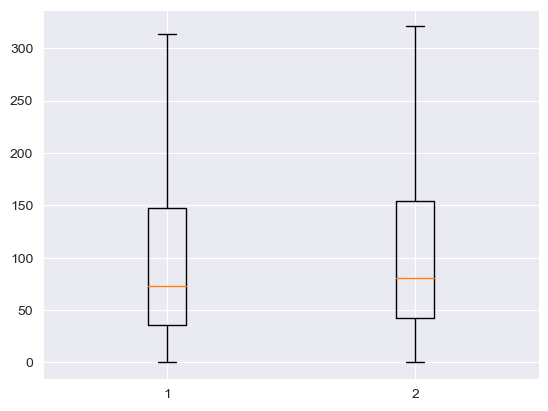

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.boxplot([ifmha['arc_length'], ifmha['wetted_perimeter']], showfliers=False)
plt.show()

In [16]:
ifmha.loc[:, 'manning_roughness1'] = (1.49 * ifmha['SLOPE']**0.5 * ifmha['chan_area']**(5.0/3.0)) / (ifmha['chan_discharge'] * ifmha['arc_length']**(2.0/3.0))
# ifmha['manning_roughness2'] = (1.49 * ifmha['SLOPE']**0.5 * ifmha['chan_area']**(5.0/3.0)) / (ifmha['chan_discharge'] * ifmha['arc_length2']**(2.0/3.0))
ifmha.loc[:, 'manning_roughness2'] = (1.49 * ifmha['SLOPE']**0.5 * ifmha['chan_area']**(5.0/3.0)) / (ifmha['chan_discharge'] * ifmha['wetted_perimeter']**(2.0/3.0))
# ifmha['jarrett_roughness'] = 0.39 * ifmha['SLOPE']**0.38 * ifmha['hydraulic_radius']**-0.16

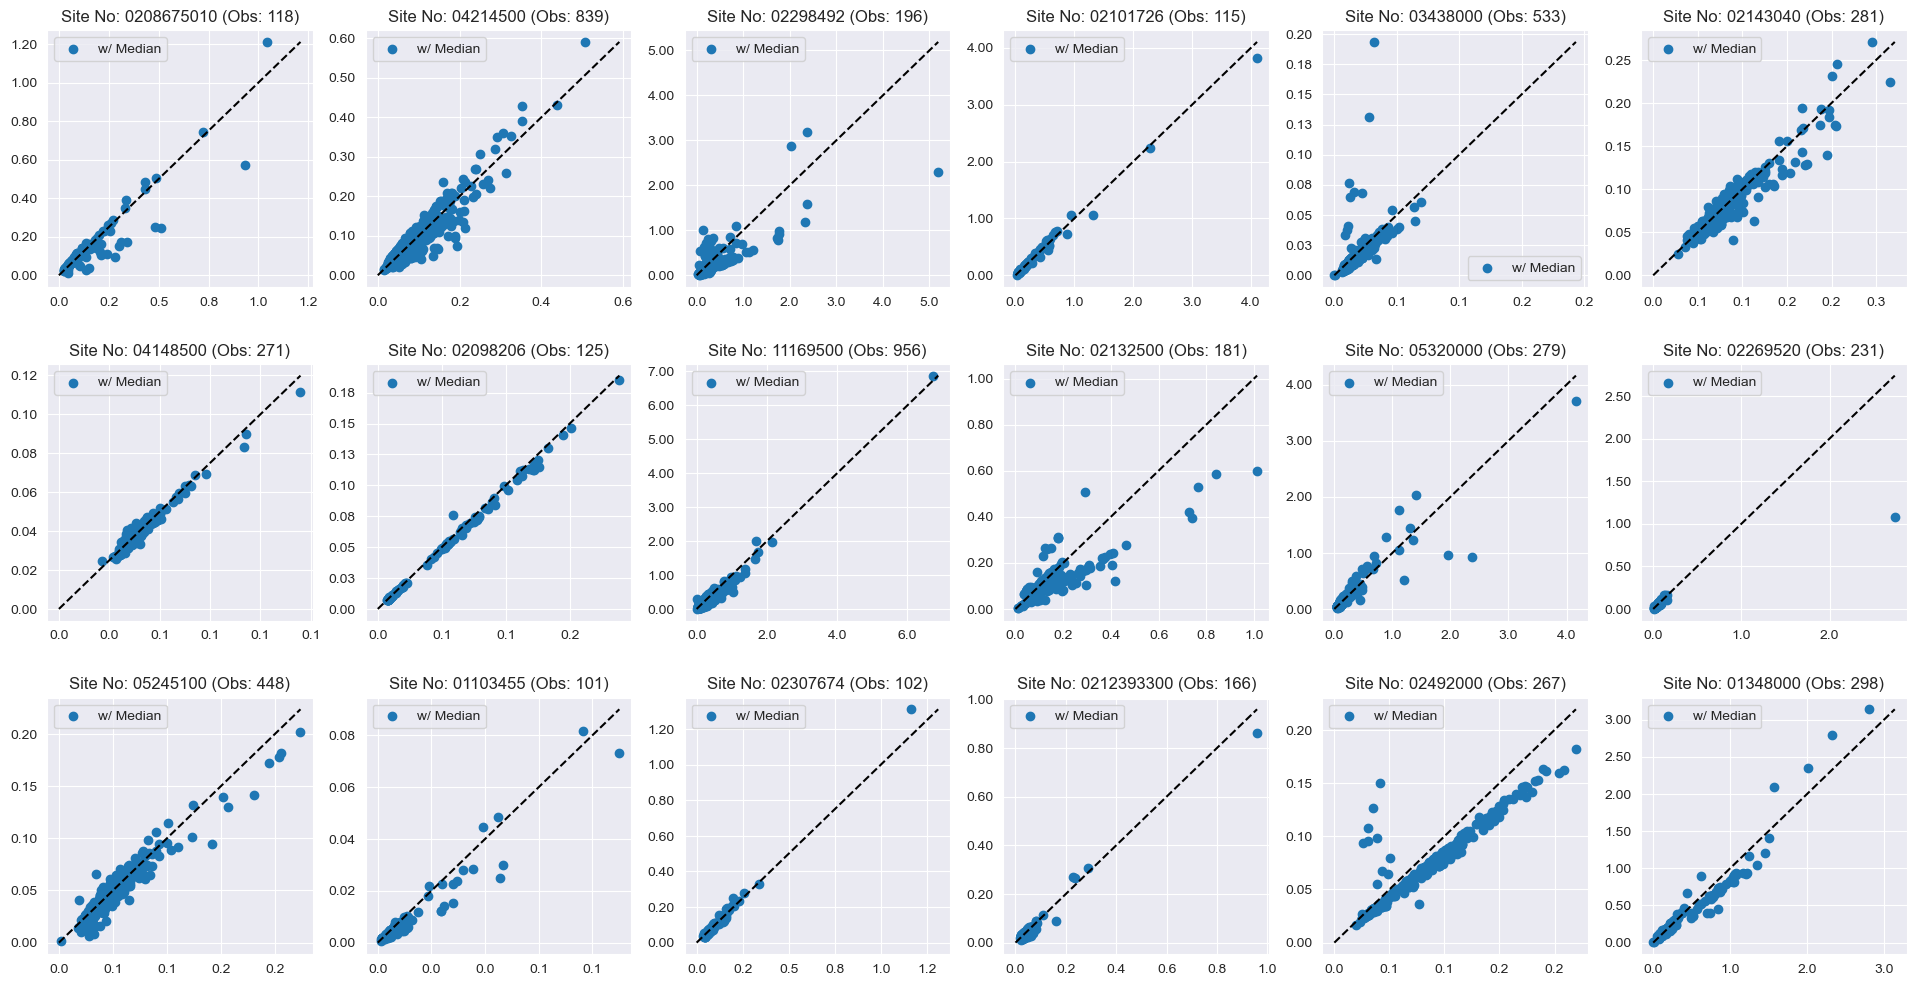

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(nrows=3, ncols=6 , figsize=(24, 12), constrained_layout=False)

np.random.seed(1)
random_sites = np.random.randint(0, 6169, 18).tolist()
# random_sites = range(0, 64, 1)

for idx, gp in enumerate(ifmha['site_no'].value_counts().index[random_sites]):

    pct = 5 / 100
    df = ifmha[ifmha['site_no'] == gp]
    # df = df[(df['chan_max_depth'] > df['chan_max_depth'].quantile(0.005)) & (df['chan_max_depth'] < df['chan_max_depth'].quantile(1-0.005))]
    # df = df[(df['manning_roughness'] > df['manning_roughness'].quantile(0.005)) & (df['manning_roughness'] < df['manning_roughness'].quantile(1-0.005))]
    # df = df[(df['chan_discharge'] > df['chan_discharge'].quantile(pct)) & (df['chan_discharge'] < df['chan_discharge'].quantile(1-pct))]

    x = df['manning_roughness1'].values
    y1 = df['manning_roughness2'].values
    # y2 = df['manning_roughness3'].values
    
    max_value = np.array((x, y1)).max()

    i, j = divmod(idx, 6)
    axes[i, j].scatter(x, y1, label='w/ Median')
    # axes[i, j].scatter(x, y2, label='w/ Trapezoid')
    axes[i, j].plot([0, max_value], [0, max_value], '--', color='black', linewidth=1.5)
    axes[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[i, j].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # axes[i, j].set_ylim(0.01, 0.5)
    axes[i, j].set_title(f"Site No: {gp} (Obs: {len(x)})")
    axes[i, j].legend()

plt.subplots_adjust(hspace=0.3) # (left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
# plt.savefig(f'./roughness-sites.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [34]:
data = ifmha.groupby('site_no')['manning_roughness1'].apply('median').reset_index(drop=False)
data.loc[:, 'manning_roughness2'] = ifmha.groupby('site_no')['manning_roughness2'].apply('median').values
data.head(100)

,site_no,manning_roughness1,manning_roughness2
0,01010000,0.101915,0.105527
1,01010070,0.069346,0.069677
2,01011000,0.056589,0.056064
3,01014000,0.004821,0.004851
4,01017000,0.019564,0.019551
...,...,...,...
95,01089500,0.066294,0.060121
96,01089925,0.016886,0.017027
97,01090800,0.059375,0.058665
98,01091000,0.117867,0.117074


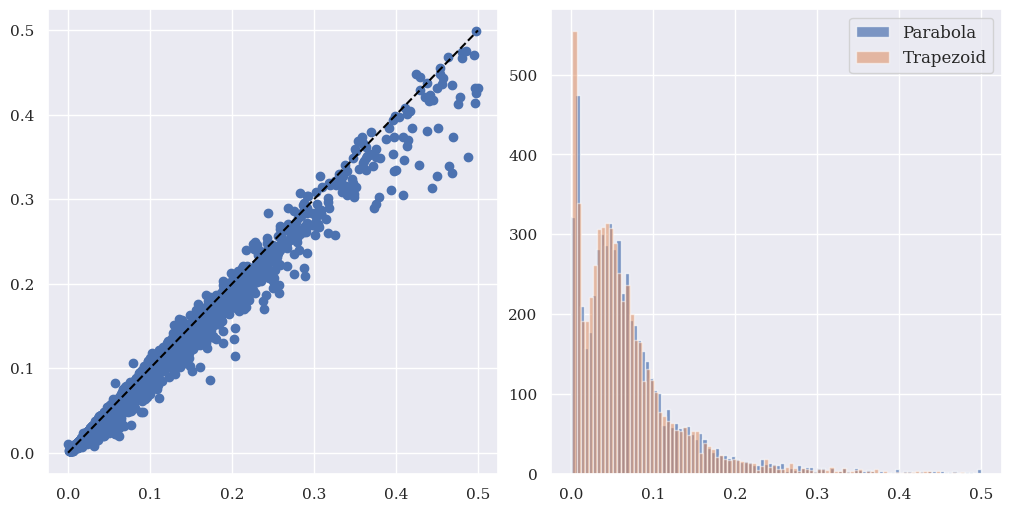

In [39]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

plt.rcParams.update({
    # 'font.sans-serif': 'Comic Sans MS',
    'font.family': 'serif',
    'font.size'   : 40
})

# font = {'family' : 'serif',
#         'weight' : 'normal',
#         'size'   : 200}
#
# matplotlib.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)

data = ifmha.groupby('site_no')['manning_roughness1'].apply('median').reset_index(drop=False)
data.loc[:, 'manning_roughness2'] = ifmha.groupby('site_no')['manning_roughness2'].apply('median').values


data = data[(data[['manning_roughness1', 'manning_roughness2']] < 0.5).all(axis=1)]

max_value = np.max((data['manning_roughness1'].values, data['manning_roughness2'].values))

ax1.scatter(data['manning_roughness1'].values, data['manning_roughness2'].values)
ax1.plot([0, max_value], [0, max_value], '--', color='black', linewidth=1.5)

ax2.hist(data['manning_roughness1'].values, bins=100, alpha=0.7, label= "Parabola" )
ax2.hist(data['manning_roughness2'].values, bins=100, alpha=0.5, label="Trapezoid")
ax2.legend(fontsize=12)

# plt.savefig(f'./roughness.svg', format='svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [40]:
(data['manning_roughness1'] > data['manning_roughness2']).sum()

4836

In [11]:
# ifmha_site_count = ifmha['site_no'].value_counts().reset_index(drop=False)
# ifmha_site_count.rename(columns={'index': 'site_no', 'site_no': 'count'}, inplace=True)
# ifmha_site_count

In [17]:
ifmha_subset = ifmha[(ifmha['SLOPE']>0.002) & (ifmha['SLOPE']<0.04) & (ifmha['hydraulic_radius'] > 0.5)]
ifmha_site_count = ifmha_subset['site_no'].value_counts().reset_index(drop=False)
ifmha_site_count.rename(columns={'index': 'site_no', 'site_no': 'count'}, inplace=True)
ifmha_site_count

,site_no,count
0,06790500,2201
1,01421000,1224
2,05412500,1103
3,03441000,1056
4,01420500,1034
...,...,...
2132,01104475,22
2133,01589316,21
2134,09404208,18
2135,02207135,18


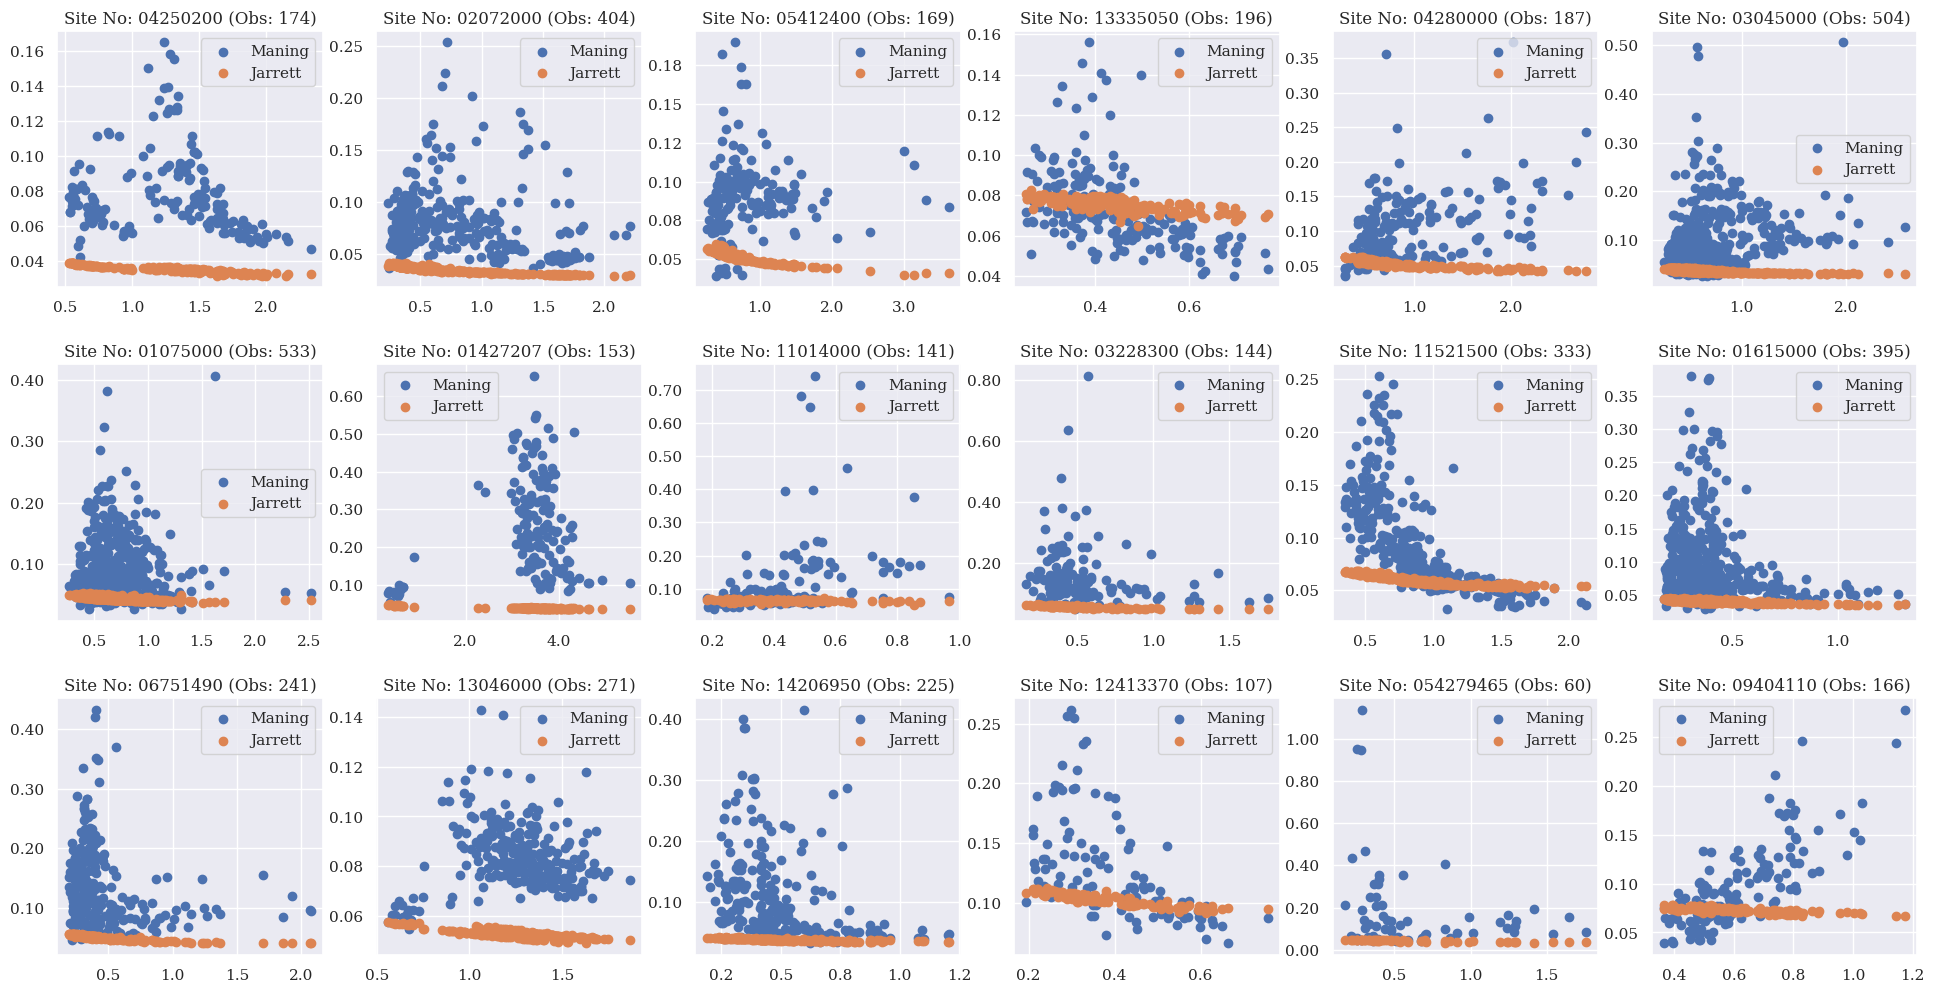

In [62]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(nrows=3, ncols=6 , figsize=(24, 12), constrained_layout=False)

np.random.seed(1)
random_sites = np.random.randint(0, 2137, 18).tolist()
# random_sites = range(0, 64, 1)

for idx, (_, gp) in enumerate(ifmha_site_count.iloc[random_sites].iterrows()):

    pct = 5 / 100
    df = ifmha_subset[ifmha_subset['site_no'] == gp['site_no']]
    df = df[(df['chan_max_depth'] > df['chan_max_depth'].quantile(0.005)) & (df['chan_max_depth'] < df['chan_max_depth'].quantile(1-0.005))]
    df = df[(df['manning_roughness'] > df['manning_roughness'].quantile(0.005)) & (df['manning_roughness'] < df['manning_roughness'].quantile(1-0.005))]
    df = df[(df['chan_discharge'] > df['chan_discharge'].quantile(pct)) & (df['chan_discharge'] < df['chan_discharge'].quantile(1-pct))]

    x = df['chan_max_depth'].values * 0.3048
    # y = df['chan_width'].values * 0.3048
    y = df['manning_roughness'].values
    y2 = df['jarrett_roughness'].values

    i, j = divmod(idx, 6)
    axes[i, j].scatter(x, y, label='Maning')
    axes[i, j].scatter(x, y2, label='Jarrett')
    axes[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[i, j].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # axes[i, j].set_ylim(0.01, 0.5)
    axes[i, j].set_title(f"Site No: {gp['site_no']} (Obs: {len(x)})")
    axes[i, j].legend()

plt.subplots_adjust(hspace=0.3) # (left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.savefig(f'./roughness-sites.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [22]:
def cal_manning_n(x):
    pct = 5 / 100
    x = x[(x['chan_discharge'] > x['chan_discharge'].quantile(pct)) & (x['chan_discharge'] < x['chan_discharge'].quantile(1-pct))]

    if x['manning_roughness'].median() <= 0.4745:
        return x['manning_roughness'].median()

    return np.nan

def cal_jarrett_n(x):
    pct = 5 / 100
    x = x[(x['chan_discharge'] > x['chan_discharge'].quantile(pct)) & (x['chan_discharge'] < x['chan_discharge'].quantile(1-pct))]

    return x['jarrett_roughness'].median()

In [23]:
manning_n = ifmha.groupby('site_no').apply(cal_manning_n).reset_index(drop=False).rename(columns={0: 'roughness'})
jarret_n = ifmha_subset.groupby('site_no').apply(cal_jarrett_n).reset_index(drop=False).rename(columns={0: 'roughness'})

In [66]:
manning_n[(~manning_n['roughness'].isna()) & (~manning_n['site_no'].isin(jarret_n['site_no'].tolist()))].shape

(4013, 2)

In [27]:
manning_n_com =  manning_n[(~manning_n['roughness'].isna()) & (manning_n['site_no'].isin(jarret_n['site_no'].tolist()))]
jarret_n_com =  jarret_n[jarret_n['site_no'].isin(manning_n_com['site_no'].tolist())]

In [63]:
print(manning_n_com['roughness'].median(), jarret_n_com['roughness'].median())
print(manning_n_com.shape, jarret_n_com.shape)

0.09682009222526065 0.04803106159419611
(2107, 2) (2107, 2)


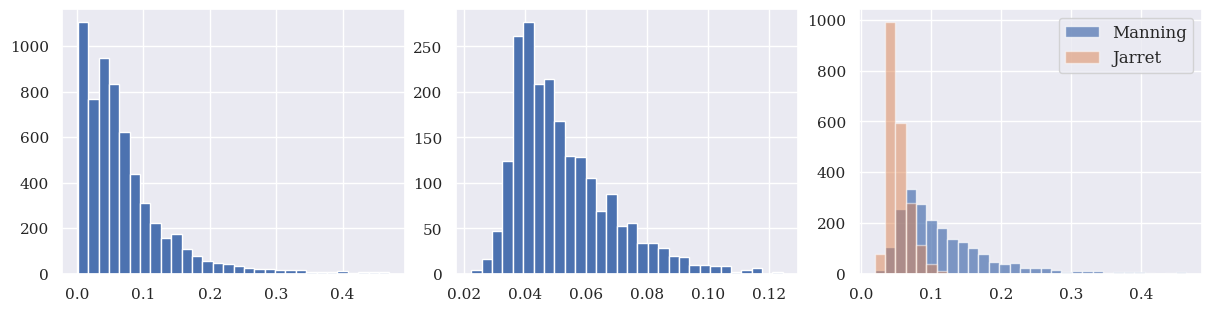

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

plt.rcParams.update({
    # 'font.sans-serif': 'Comic Sans MS',
    'font.family': 'serif',
    'font.size'   : 40
})

# font = {'family' : 'serif',
#         'weight' : 'normal',
#         'size'   : 200}
#
# matplotlib.rc('font', **font)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 3), constrained_layout=True)

ax1.hist(manning_n['roughness'].values, bins=30)
ax2.hist(jarret_n['roughness'].values, bins=30)
data1 = manning_n_com['roughness']
data2 = jarret_n_com['roughness']
ax3.hist(data1.values, bins=30, range=(np.min(data1), np.max(data1)), alpha=0.7, label= "Manning" )
ax3.hist(data2.values, bins=30, range=(np.min(data1), np.max(data1)), alpha=0.5, label="Jarret")
ax3.legend(fontsize=12)

plt.savefig(f'./roughness.svg', format='svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [17]:
# https://www.hydroshare.org/resource/0a596929a3e5411bb0032a8de35e5089/
ds = nc.Dataset('./data/RouteLink_CONUS.nc/RouteLink_CONUS.nc')
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Convention: CF-1.6
    featureType: timeSeries
    processing_notes: This file was produced Fri Apr 12 07:16:15 2019 by Kevin Sampson (NCAR) and has the following attributes: 
   This file uses the NHDPlus v21 "flattened" geodatabase: NHDPlusV21_National_Flattened.gdb.
   This file excludes reaches in Puerto Rico and Hawaii.
   Routing using Arc-Hydro derived segments for Regions 01a, 02b, 09a, 10i, 10h, 13a, 13b, 13d, 15a, 15b, 17b, 18a.
   Topology fixes using: Topology_Fixer.csv.
   NHDFlowlines removed using: Remove_COMIDs_NHDFLowline_Network.csv.
   Gage preference list: numberOf100QualityObs.2017-03-15.csv.
   Gage subset list: numberOf100QualityObs.2017-03-15.csv.
   Gage additions made using: Add_Gage_Association.csv.
   Gage-to-flowline association changes made using: Bad_Gage_Associations.csv.
   Tidal-influenced gages removed using: TidalGageList_20170316.csv.
   Waterbody assoc

In [6]:
print(ds.__dict__)

{'Convention': 'CF-1.6', 'featureType': 'timeSeries', 'processing_notes': 'This file was produced Fri Apr 12 07:16:15 2019 by Kevin Sampson (NCAR) and has the following attributes: \n   This file uses the NHDPlus v21 "flattened" geodatabase: NHDPlusV21_National_Flattened.gdb.\n   This file excludes reaches in Puerto Rico and Hawaii.\n   Routing using Arc-Hydro derived segments for Regions 01a, 02b, 09a, 10i, 10h, 13a, 13b, 13d, 15a, 15b, 17b, 18a.\n   Topology fixes using: Topology_Fixer.csv.\n   NHDFlowlines removed using: Remove_COMIDs_NHDFLowline_Network.csv.\n   Gage preference list: numberOf100QualityObs.2017-03-15.csv.\n   Gage subset list: numberOf100QualityObs.2017-03-15.csv.\n   Gage additions made using: Add_Gage_Association.csv.\n   Gage-to-flowline association changes made using: Bad_Gage_Associations.csv.\n   Tidal-influenced gages removed using: TidalGageList_20170316.csv.\n   Waterbody associations using spatial join with Lake feature class Input_Waterbodies_NWM_v2_1.shp

In [8]:
for var in ds.variables.values():
    print(var)

<class 'netCDF4._netCDF4.Variable'>
int32 link(feature_id)
    long_name: Link ID (NHDFlowline_network COMID)
    cf_role: timeseries_id
    coordinates: lat lon
unlimited dimensions: 
current shape = (2776738,)
filling on, default _FillValue of -2147483647 used
<class 'netCDF4._netCDF4.Variable'>
int32 from(feature_id)
    long_name: From Link ID (PlusFlow table FROMCOMID for every TOCOMID)
    coordinates: lat lon
unlimited dimensions: 
current shape = (2776738,)
filling on, default _FillValue of -2147483647 used
<class 'netCDF4._netCDF4.Variable'>
int32 to(feature_id)
    long_name: To Link ID (PlusFlow table TOCOMID for every FROMCOMID)
    coordinates: lat lon
unlimited dimensions: 
current shape = (2776738,)
filling on, default _FillValue of -2147483647 used
<class 'netCDF4._netCDF4.Variable'>
float32 lon(feature_id)
    long_name: longitude of the segment midpoint
    units: degrees_east
    standard_name: longitude
    coordinates: lat lon
unlimited dimensions: 
current shape =

In [18]:
ds_dict = {'COMID': ds['link'][:], 'side_slope': 1/ds['ChSlp'][:], 'bottom_width': ds['BtmWdth'][:], 'compound_manning': ds['nCC'][:], 'manning': ds['n'][:]}

In [19]:
nwm = pd.DataFrame.from_dict(ds_dict)

## Channel Side Slope & Bottom Width

In [20]:
ifmha_v1 = ifmha.drop_duplicates(subset='site_no', keep='first')
print(np.sum(ifmha_v1['COMID'].value_counts() > 1)) # counting number of COMIDS that includes more than one gage station

60


In [21]:
ifmha_v1 = ifmha_v1.groupby("COMID").apply(lambda x: x[['side_slope', 'chan_bottom_width']].mean()).reset_index(drop=False)

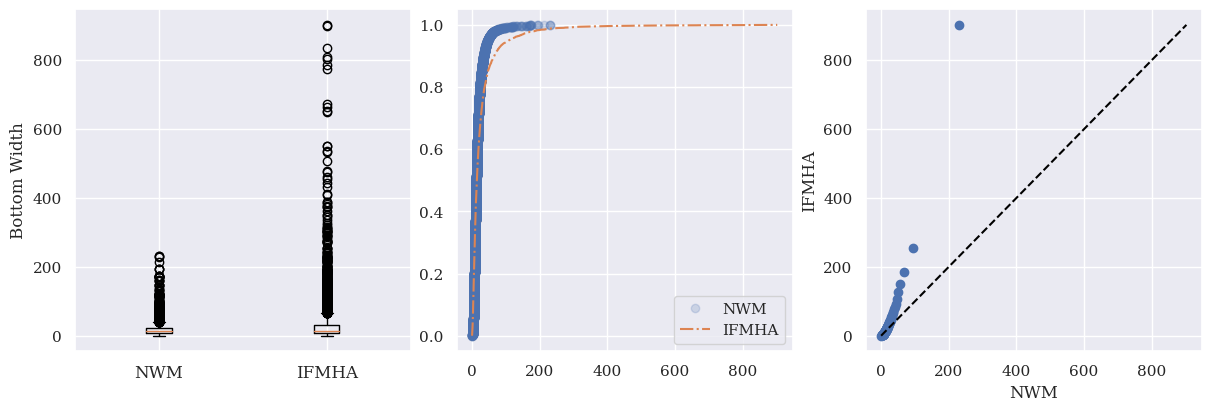

In [38]:
from utils import qqplot
data1 = ifmha_v1[ifmha_v1['COMID'].isin(nwm['COMID'].tolist())]['chan_bottom_width'].values
data1 = 0.3048 * data1
data2 = nwm[nwm['COMID'].isin(ifmha_v1['COMID'].tolist())]['bottom_width'].values

pct = 0.005
data1 = data1[(data1 > np.quantile(data1, pct)) & (data1 < np.quantile(data1, 1-pct))]
data2 = data2[(data2 > np.quantile(data1, pct)) & (data2 < np.quantile(data2, 1-pct))]

qqplot(data2, data1, yax1='Bottom Width', axis_names=['NWM', 'IFMHA'], quantiles=100)

In [36]:
pd.DataFrame({'NWM': data2}).describe()

,NWM
count,6052.000000
mean,17.254055
std,14.547583
min,1.006404
25%,8.339229
50%,13.069252
75%,20.869346
max,121.254684


In [39]:
pd.DataFrame({'IFMHA': data1}).describe()

,IFMHA
count,6092.000000
mean,30.283880
std,56.013036
min,0.016020
25%,6.931305
50%,14.535846
75%,30.756530
max,902.605741
